<a href="https://colab.research.google.com/github/rlagosb/taller_eiv/blob/main/2_Ejercicio_Normalizaci%C3%B3n_(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Normalización de datos

En este ejercicio vamos normalizar los datos de la demanda y la oferta de consultas de especialidad médica en el Servicio de Salud Metropolitano Sur Oriente en 2021. Vamos a  organizar los datos de manera eficiente para minimizar la redundancia y mejorar la integridad de los datos. Para ello es necesario:

1. Identificar las entidades y relaciones en un diagrama E-R
1. Normalizar datos de Demanda (interconsultas)
1. Normalizar datos de Especialidades
3. Normalizar datos de Oferta (producción, programación)

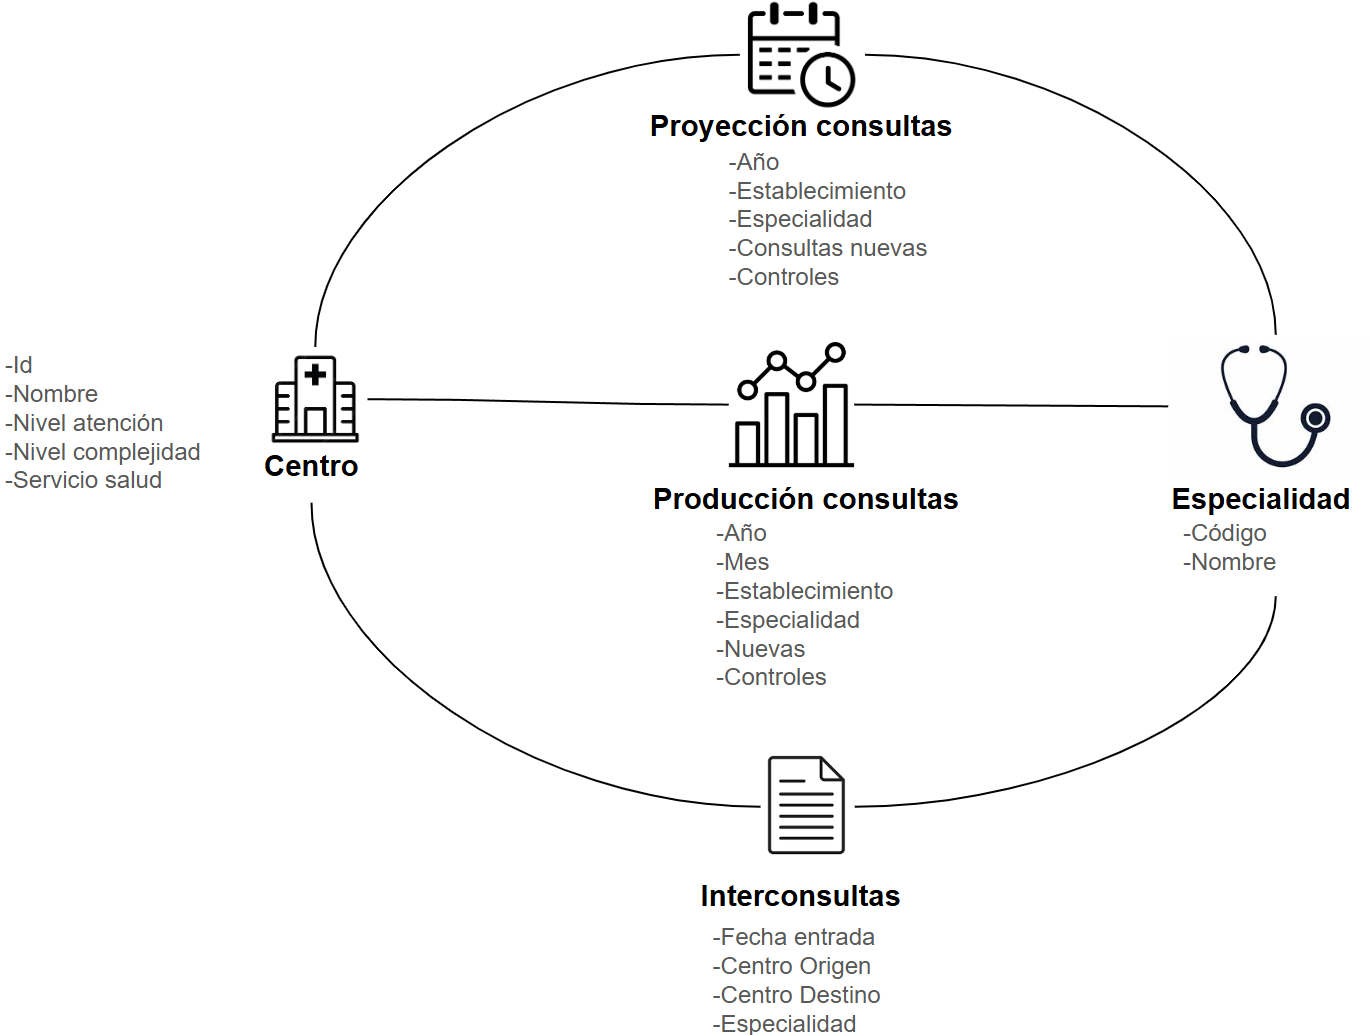

## Modelo Entidad-Relación

Primero es necesario tener un esquema de qué describen los datos e identificar las tablas necesarias. En este ejercicio podemos identificar as entidades:

- Centro de salud
- Especialidad
- Demanda entrante (interconsultas nuevas)
- Demanda acumulada (lista de espera al inicio del periodo)
- Capacidad (producción histórica)
- Programación


# Configurar área de trabajo

In [ ]:
# Importar librerías
import pandas as pd
import os

# Definir carpetas de trabajo
datos_originales = 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/data/'
datos_crudos = 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/datos_crudos/'
datos_normalizados = '/content/datos_normalizados/'

# Crear carpetas
if not os.path.exists(datos_crudos): os.makedirs(datos_crudos)
if not os.path.exists(datos_normalizados): os.makedirs(datos_normalizados)

In [ ]:
# cargar datos
sic = pd.read_parquet(datos_crudos + 'sic_2021_SSMSO.parquet')
programacion = pd.read_parquet(datos_crudos + 'programacion_2021_SSMSO.parquet')
produccion = pd.read_parquet(datos_crudos + 'rem_A07_2021_SSMSO.parquet')

# 1- Normalizar demanda (solicitudes de interconsulta)

In [ ]:
# Examinemos la fuente de los datos de demanda
# ¿Cuáles campos son redundantes o innecesarios para nuestro análisis?
print(sic.info())
sic.sample(5)

In [ ]:
demanda = sic[['PRESTA_MIN','F_ENTRADA','ESTAB_DEST']]

demanda

In [ ]:
# Usaremos sólo el mes y año y botaremos la fecha exacta de la interconsulta
demanda.loc[:,'Año']=demanda['F_ENTRADA'].dt.year
demanda.loc[:,'Mes']=demanda['F_ENTRADA'].dt.month
del demanda['F_ENTRADA']

In [ ]:
# Con los datos normalizados podemos agregar los registros y usar un contador
demanda = demanda.value_counts().reset_index()

demanda.rename(columns={'count':'Interconsultas',
                        'PRESTA_MIN':'Especialidad',
                        'ESTAB_DEST':'Centro_destino',
                        },
               inplace=True)

# Revisamos el dataframe resultante
print(demanda.info())
print(demanda.describe())
demanda.sample(5)

In [ ]:
# Exportar a la carpeta de Datos Normalizados
demanda.to_excel(datos_normalizados + 'Demanda.xlsx',index=False)

## 🏁 Discusión

1. ¿Qué datos se perdieron al normalizar y agrupar los datos de demada?
2. ¿En qué incide?
3. Si más adelante necesitara incluir alguna de las variables que se perdieron, ¿qué tendría que hacer?

# 2- Normalizar especialidades

Debemos elegir un estándar para identificar las especialidades de las consultas médicas en nuestro análisis. Note que las solicitudes de interconsulta (sic) y la producción tienen distinta codificación.

In [ ]:
print(sic.PRESTA_MIN.value_counts().head(3),end='\n\n')
print(produccion.CodigoPrestacion.value_counts().head(3))

Debemos crear una tabla maestra **especialidades**.  Utilizaremos la [Norma Técnica 820 de Estándares de Información de Salud](https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/EstandaresNormativa/Decreto-Exento-643-Sustituye-Norma-T%C3%A9cnica-sobre-Est%C3%A1ndares-de-Informaci%C3%B3n-de-Salud-Actualizada-a-Dic-2016.pdf) en que están codificadas las especialidad de las interconsultas.

In [ ]:
# Obtenemos el diccionario de códigos de especialidades médicas de las interconsultas
especialidades = pd.read_excel(datos_originales + 'SS_MSOr_Respuesta%20Solicitud%20Folio%20AO012T0001655%20(CNE%202021).xlsx',
                               sheet_name='diccionario',
                               header=None,
                               usecols="A:B",
                               names=['Codigo','Nombre'],
                               skiprows=47,
                               nrows=68)
especialidades

## 🏁 Discusión
1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Cuál es el identificador (llave primaria) de una especialidad?
1. ¿Qué atributos tiene cada Especialidad?

## Agregar Especialidad_programacion
Ahora agregaremos la codificación de la Programación (que es la misma que la Producción) a la tabla Especialidades

In [ ]:
# Creamos una tabla auxiliar con las especialidades de la programación
especialidades_prog = pd.read_excel(datos_originales + 'programacion/114101_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx',
                                   sheet_name='Diccionarios',
                                   header=None,
                                   usecols='B:C',
                                   names=['Codigo_prog','Nombre_prog'],
                                   skiprows=2,
                                   nrows=64)
especialidades_prog

Para comparar las especialidades de dos fuentes de información necesitamos hacer un [JOIN](https://agscl.github.io/Est-Aplicada-UDP-2024/Clase4.html#11) (cruce) de tablas.

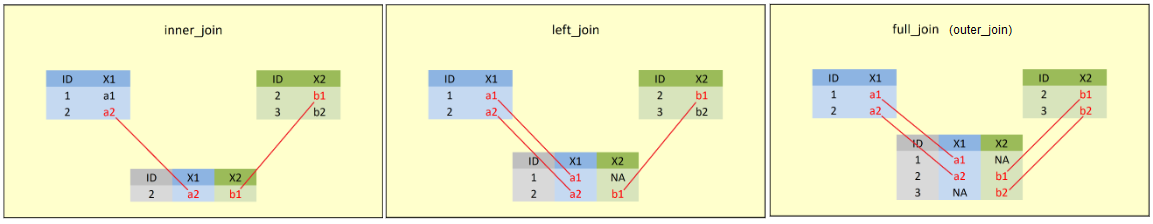


In [ ]:
# cruzamos ambos diccionarios y revisamos las especialidades sin match
# outer join permite hacer el cruce de dos dataframes conservando los registros incompatibles de ambos
cruce = especialidades.merge(especialidades_prog,
                                       left_on='Nombre',
                                       right_on='Nombre_prog',
                                       how='outer')

cruce

In [ ]:
# obtenemos las especialidades de programación que no coinciden
# observe que obtenemos los datos en formato array en vez de un dataframe
cruce['Nombre_prog'][cruce['Nombre'].isna()].array

In [ ]:
# obtenemos las especialidades 820 sin match
cruce['Nombre'][cruce['Nombre_prog'].isna()].array

In [ ]:
# homologamos a la norma 820 las especialidades de programación sin match
# por ej., el original CARDIOLOGÍA ADULTO lo adaptamos a CARDIOLOGÍA
match_especialidad={'CARDIOLOGÍA ADULTO':'CARDIOLOGÍA',
     'CIRUGÍA DIGESTIVA (ALTA)':'CIRUGÍA DIGESTIVA',
     'CIRUGÍA GENERAL ADULTO':'CIRUGÍA GENERAL',
     'CIRUGÍA PLÁSTICA Y REPARADORA ADULTO':'CIRUGÍA PLÁSTICA Y REPARADORA',
     'CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA':'CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA',
     'CIRUGÍA TÓRAX':'CIRUGÍA DE TÓRAX',
     'COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)':'COLOPROCTOLOGÍA',
     'ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)':'ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)',
     'ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)':'ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)',
     'GINECOLOGÍA ADULTO':'GINECOLOGÍA',
     'HEMATO-ONCOLOGÍA INFANTIL':'HEMATO-ONCOLOGÍA PEDIÁTRICA',
     'HEMATOLOGÍA ADULTO':'HEMATOLOGÍA',
     'INFECTOLOGÍA ADULTO':'INFECTOLOGÍA',
     'INFECTOLOGÍA PEDIÁTRICA':'INFECTOLOGÍA PEDIATRICA',
     'LABORATORIO CLINICO':'LABORATORIO CLÍNICO',
     'MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)':'MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)',
     'MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)':'MEDICINA FISICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRIA PEDIATRICA)',
     'MEDICINA INTENSIVA':'MEDICINA INTENSIVA ADULTO',
     'MEDICINA NUCLEAR (EXCLUYE INFORMES)':'MEDICINA NUCLEAR',
     'NEFROLOGÍA PEDIÁTRICA':'NEFROLOGÍA PEDIÁTRICO',
     'NUTRIÓLOGO ADULTO':'NUTRIÓLOGO',
     'REUMATOLOGÍA ADULTO':'REUMATOLOGÍA',
     'TRAUMATOLOGÍA Y ORTOPEDIA ADULTO':'TRAUMATOLOGÍA Y ORTOPEDIA',
     'UROLOGÍA ADULTO':'UROLOGÍA'}

def completar_especialidad(nombre_programacion):
  if nombre_programacion in match_especialidad.keys():
    return match_especialidad[nombre_programacion]
  else:
    return nombre_programacion

# creamos un campo con las especialidades de la programación homologadas a la norma 820
cruce['Nombre_fix']=cruce['Nombre_prog'].apply(completar_especialidad)

# Revisamos las especialidades de programación y su nombre original y el homologado
cruce[['Codigo_prog','Nombre_prog','Nombre_fix']].dropna()

In [ ]:
# Agregamos el código de las especialidades de programación al maestro
# para ello cruzamos el maestro con las especialidades de programación homologadas
especialidades = especialidades.merge(cruce[['Codigo_prog','Nombre_prog','Nombre_fix']].dropna(),
                     how='left',
                     left_on='Nombre',
                     right_on='Nombre_fix')
especialidades

In [ ]:
# Eliminamos el campo que utilizamos para homologar ambos diccionarios
del especialidades['Nombre_fix']

# Vemos el diccionario especialidades para nuestro análisis
especialidades

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
1. ¿Cuántas especialidades se programan en nuestra base de datos?

## Agregar especialidades REM

In [ ]:
# Obtenemos los códigos de las prestaciones del REM de consultas de especialidad
especialidades_rem = produccion[['CodigoPrestacion']].drop_duplicates()

# Cambiamos el nombre
especialidades_rem.rename(columns={'CodigoPrestacion':'Codigo_rem'},inplace=True)
especialidades_rem

In [ ]:
# Cruzamos las especialidades REM con las especialidades de programación del diccionario
cruce_rem = especialidades.merge(especialidades_rem,
                         how='outer',
                         left_on='Codigo_prog',
                         right_on='Codigo_rem')

# Vemos el resultado
cruce_rem

In [ ]:
# ¿Qué prestaciones REM no son homologables al maestro de especialidades?
cruce_rem[cruce_rem.Codigo.isna()]

In [ ]:
# Note que radioterapia oncológica si está en el diccionario, ¡pero con otro código!
especialidades[especialidades.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA']

In [ ]:
# Corregimos manualmente el Codigo REM de radioterapia oncológica en el cruce_rem
cruce_rem.loc[cruce_rem.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA', 'Codigo_rem'] = 7030500
cruce_rem[cruce_rem.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA']

In [ ]:
# Agregamos el código REM al maestro de especialidades
especialidades = especialidades.merge(cruce_rem[['Codigo','Codigo_rem']].dropna(),
                                       how='left',
                                       left_on='Codigo',
                                       right_on='Codigo')

# Vemos el resultado
especialidades

In [ ]:
# Agregamos el diccionario a la base de datos normalizados
especialidades.to_excel(datos_normalizados + 'Especialidades.xlsx',index=False)

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
3. ¿Qué significa que una especialidad del diccionario no tenga código REM o de programación? ¿Es una inconsistencia?
2. ¿Qué pasa si una especialidad no tiene código norma 820? ¿Es una inconsistencia?

# 🍎 Desafío 1: Normalizar Producción

1. Obtenga los datos REM (```rem_A07_2021_SSMSO.parquet```) de la carpeta de *datos_crudos* y examine la información que contiene
2. Genere un dataframe con las columnas:
  - Año
  - Mes
  - IdEstablecimiento
  - CodigoPrestacion
  - ConsultasTotales (utilice los datos de `Col1`)
  - ConsultasNuevas (utilice `Col22 + Col26`)
  - Controles (`ConsultasTotales - ConsultasNuevas`)
3. Codifique las prestaciones con la norma 820. Para ello:
  - Cambie el nombre de *CodigoPrestacion* por *Codigo_rem*
  - Agrege el campo *Especialidad* de la tabla *Especialidades* con un *Join* en base al campo *Codigo_rem*
  - Elimine el campo *Codigo_rem*
4. Guarde el dataframe resultante en la carpeta *datos_normalizados*

# 🍎 Desafío 2: Normalizar Programación